### Step 1
Activate the Plastid conda environment and open up a Jupyter Lab session (alternatively, a python file can be run in this python environment)

### Step 2
Load in all of the necessary Python packages.

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from plastid.plotting.plots import *
from scipy import stats
from scipy.stats import kstwo
from statsmodels.stats.proportion import proportions_ztest
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy
import seaborn as sns

In [3]:
# Define the path to our data files and the path we want to save our outputs in. 
target_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Larp1_targets/'
ks_human_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/human/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
samp_num = '2'

### Step 3
Load up a table containing a list of targets for your mutant gene and load up the KS table you created during the previous section using pandas pd.read_csv().

In [4]:
# Load up the target gene names. 
Larp1_table = pd.read_csv(target_path + 'Top_containing_genes.csv', names = ["gene_name"])

# Load up the tables of KS statistics
df_human = pd.read_csv(ks_human_path + "ks_table_" + samp_num + ".csv")

### Step 4
Merge the table of KS statistics and the table of targets into a new table using pd.merge()

In [5]:
# Merge the ecoli ks table with the list of gene names
Larp1_ks_table = pd.merge(df_human, Larp1_table, how='inner', right_on='gene_name', left_on='gene_ID')

combo_df = pd.merge(df_human, Larp1_table, how='left', right_on='gene_name', left_on='gene_ID')

### Step 5
Clean up your new table by removing any duplicates that may have been caused by multiple transcripts having the same gene name. 

In [6]:
# Keep only one copy of each gene in the Larp1 table. 
Larp1_ks_table.drop_duplicates(subset ="gene_name",keep = "first", inplace = True) 

df_human.drop_duplicates(subset ="gene_ID",keep = "first", inplace = True) 

combo_df.drop_duplicates(subset ="gene_ID",keep = "first", inplace = True) 

### Step 6
Look at the KS statistic from the control mutant comparisons for all genes and for just the Fmr1 targets. This will help you get an initial sense for how you want to divide up the low, medium, and high KS fractions. For both the merged table and the original table of KS statistics, sort the KS values from smallest to largest using the sorted() function and then plot them as a scatter plot.

(0.0, 0.7)

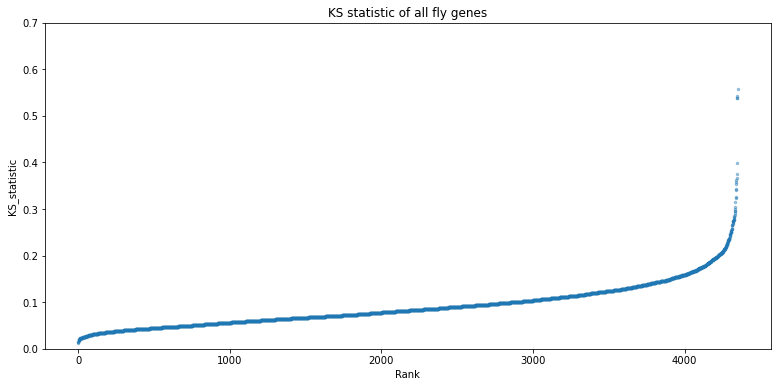

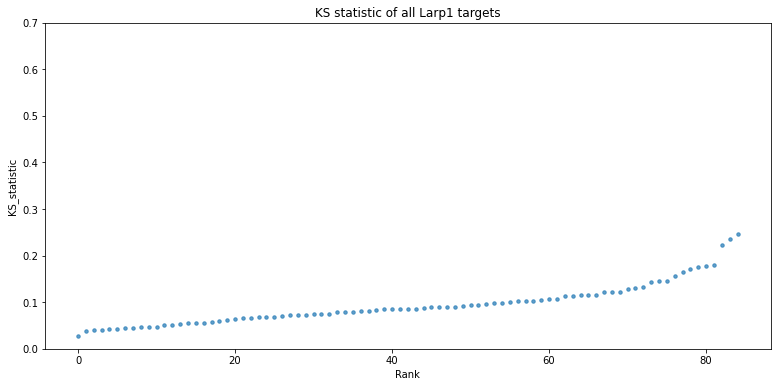

In [7]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (13,6))
plt.scatter(list(range(len(df_human["ks_stat"]))), sorted(df_human["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all fly genes")
plt.ylim(0,0.7)
plt.show
figure(figsize = (13,6))
plt.scatter(list(range(len(Larp1_ks_table["ks_stat"]))), sorted(Larp1_ks_table["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all Larp1 targets")
plt.ylim(0,0.7)

In [8]:
combo_df = combo_df.sort_values(by = "ks_stat")
combo_df = combo_df.reset_index()

In [9]:
targets = combo_df.dropna()
#I will need to sort everything first. 

In [10]:
targets.to_csv("/home/keeganfl/Desktop/Work_Fall_2021/raw_ks_data/human_Larp1_targets.csv", index_label = "index")

In [11]:
non_targets = combo_df[combo_df["gene_name"].isnull()]

In [12]:
non_targets.to_csv("/home/keeganfl/Desktop/Work_Fall_2021/raw_ks_data/human_non_targets.csv", index_label = "index")

(0.0, 0.7)

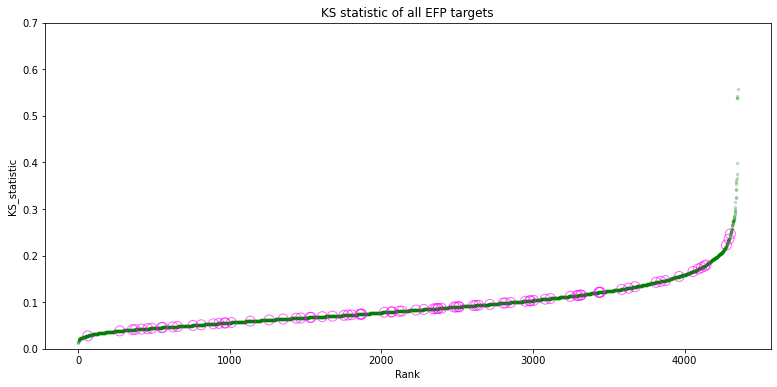

In [45]:
figure(figsize = (13,6))
plt.scatter(list(non_targets.index), non_targets["ks_stat"], s=6, alpha = 0.2, color = "g")
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all E.coli genes")
plt.ylim(0,0.7)

plt.scatter(list(targets.index), targets["ks_stat"], s=100, alpha = 0.6, facecolors = 'none', edgecolors = 'magenta')
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all EFP targets")
plt.ylim(0,0.7)

In [8]:
# print out the mean of all polyprolne motif containing genes (efp targets)
print("mean KS statistic of Larp1 target genes = " + str(np.mean(Larp1_ks_table.ks_stat)))
print("mean KS statistic of all D.mel genes = " + str(np.mean(df_human.ks_stat)))

mean KS statistic of Larp1 target genes = 0.09193389826945918
mean KS statistic of all D.mel genes = 0.0871622006891959


### Step 7
Calculate the upper KS statistic by taking the average KS stat of the top 10\% of transcripts with the highest KS stat. transcripts that have a higher KS statistic then the upper KS statistic will be within the high KS fraction. Then we choose the number of fractions we would like to observe. Then we use the determine_enrichment() function to determine the ratio between the targets and the total genes within each KS fraction.

In [9]:
# Calculate the upper KS value as the average of the 10% of transcripts with the highest KS stat. 
# The upper KS fraction will include all of the transcripts with a KS score above this value.
perc = int(len(df_human)*0.9)
upper_ks = np.mean(sorted(df_human.ks_stat)[perc:-1])

# Calculate the proportion of genes which are Larp1 targets in a high, medium, and low KS fraction
N_cats = 2
ratios_human, sections_human = kat.determine_enrichment(Larp1_ks_table, df_human, upper_ks, N_cats)

### Step 8
Use matplotlib.pyplot.bar() function to create a series of barplots that show the observed percentage of genes that are targets in each fraction. Then you can draw a a line through this barplot using matplotlib.pyplot.plot() that shows the expected percentage of genes that are targets if there is no enrichment.  

---------------------------------------------------------------------------
UserWarning
FixedFormatter should only be used together with FixedLocator
in /tmp/ipykernel_172357/2059987224.py, line 17:

15 axes = plt.gca()
16 axes.yaxis.grid(linestyle = "--")
17 axes.set_yticklabels([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
18 plt.text(3.45, expected*0.96, "All proteins", fontsize = 10)

---------------------------------------------------------------------------


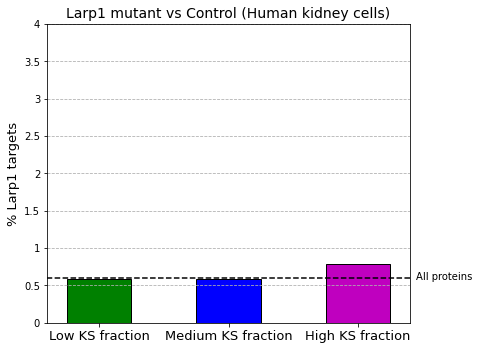

In [17]:
# Calculate the expected proportion of targets
expected = len(Larp1_ks_table.ks_stat)/len(df_human.ks_stat)

# Create a bar plot that shows the proportion of genes which are Larp1 targets in each KS fraction.
expected = len(Larp1_ks_table.ks_stat)/len(df_human.ks_stat)
figure(figsize = (6.5,5.5))
plt.bar([1,2,3],ratios_human, width = 0.5,
        tick_label = ["Low KS fraction","Medium KS fraction","High KS fraction"],
       color = ["g", 'b', 'm'], edgecolor = 'black')
plt.xticks(fontsize = 13)
plt.xlim(0.6,3.4)
plt.ylim(0, 0.04)
plt.ylabel("% Larp1 targets", fontsize = 13)
plt.title("Larp1 mutant vs Control (Human kidney cells)", fontsize = 14)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
axes.set_yticklabels([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
plt.text(3.45, expected*0.96, "All proteins", fontsize = 10)

# Create a line showing the expected proportion of targets. 
plt.plot([0,6],[expected,expected], color = "black", linestyle = "--")
plt.savefig(save_path + 'human_proportions.pdf', bbox_inches = "tight")

### Step 9
Now we want to perform a proportion Z-test to determine if the difference between our observed and expected target proportions are significant. We can use the det_p_values() function to automatically calculate these P-values for each of the KS fractions.

In [11]:
# determine if the difference betwqeen the expected proportion of targets 
# and the observed proportion of targets is significant
kat.det_p_values(Larp1_ks_table, df_human, sections_human)

[0.9157687274986958, 0.9706096925337946, 0.6319207608584559]

## Plot the distribution of the KS-statistic for all genes and for the target genes. 

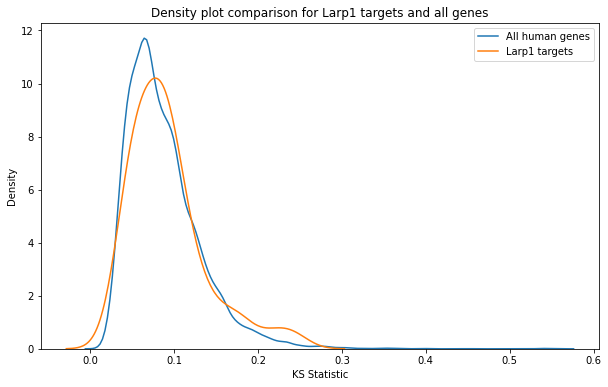

In [12]:
figure(figsize = (10,6))
sns.kdeplot(df_human.ks_stat, label = "All human genes")
sns.kdeplot(Larp1_ks_table.ks_stat, label = "Larp1 targets")
plt.ylabel("Density")
plt.xlabel("KS Statistic")
plt.title("Density plot comparison for Larp1 targets and all genes")
plt.legend()